In [ ]:
!pip install langchain
!pip install langchain-community
!pip install langchain-huggingface
!pip install sentence-transformers
!pip installa langchain-chroma

!pip install transformers
!pip install bitsandbytes
!pip install torch
!pip install huggingface-hub -q
!pip install chromadb
!pip install bert-score
!pip install "accelerate>=0.26.0"
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.29
    Uninstalling langchain-core-0.3.29:
      Successfully uninstalled langchain-core-0.3.29
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.14
    Uninstalling langchain-0.3.14:
      Successfully uninstalled langchain-0.3.14
ERROR: unknown command "installa" - maybe you meant "install"
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyp

## Importations

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.vectorstores import Chroma
from langchain.storage import LocalFileStore
from langchain.chains import LLMChain
from huggingface_hub import notebook_login
from langchain.llms import HuggingFacePipeline
from langchain_core.prompts.prompt import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate

import time
import ast
import json
import torch
import transformers
from deep_translator import GoogleTranslator
from transformers import AutoTokenizer
from typing import List, Dict
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from bert_score import score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Dataset construction

In [ ]:
airbnb1 = pd.read_csv("airbnb1.csv")
airbnb2 = pd.read_csv("airbnb2.csv")
airbnb3 = pd.read_csv("airbnb3.csv")
airbnb4 = pd.read_csv("airbnb4.csv")
airbnb5 = pd.read_csv("airbnb5.csv")
airbnb6 = pd.read_csv("airbnb6.csv")

In [ ]:
#Concatenating csv files in a final dataset
df = pd.concat([airbnb1, airbnb2, airbnb3, airbnb4, airbnb5, airbnb6], ignore_index = True)

#Selecting useful information and rename columns
df = df[['id','language','localizedText','localizedReview/localizedDate','reviewer/firstName', 'reviewer/id','startUrl']]
df = df.rename(columns={'localizedText': 'ItalianReview', 'reviewer/firstName':'reviewer_name','reviewer/id':'reviewer_id','startUrl':'url',
                        'localizedReview/localizedDate':'Date'})

In [ ]:
#English reviews to be joined in the original dataset
english_reviews1= pd.read_csv("english_reviews1.csv")
english_reviews2= pd.read_csv("english_reviews2.csv")
english_reviews3= pd.read_csv("english_reviews3.csv")

english_data = pd.concat([english_reviews1, english_reviews2, english_reviews3], ignore_index = True)
english_data = english_data.rename(columns={'localizedText':'EnglishReview'})

In [ ]:
#Combining data
data = pd.merge(df, english_data, on='id')

In [ ]:
print(f"The dataset contains {sum(data.duplicated(subset=['EnglishReview', 'reviewer_name','reviewer_id']))} duplicates")

#Dropping duplicates
data = data.drop_duplicates(subset= ['EnglishReview', 'reviewer_name','reviewer_id'])

print(f"The dataset after dropping contains {sum(data.duplicated(subset=['EnglishReview', 'reviewer_name','reviewer_id']))} duplicates")

The dataset contains 2191 duplicates
The dataset after dropping contains 0 duplicates


In [ ]:
#Check for NA values in reviews
print("The number of missing data in reviews is ", data['EnglishReview'].isnull().sum())

The number of missing data in reviews is  0


In [ ]:
#Function to transform URLs to match the ones contained in the dataset containing the information about the accomodations
def transform_url(url: str) -> str:
    base = url.split('?')[0]  # remove everything after '?'
    return base.replace("www.airbnb.it", "www.airbnb.com")

data.loc[:, "url"] = data["url"].apply(transform_url)

In [ ]:
#Visualization of the initial dataset
data.head()

,id,language,ItalianReview,Date,reviewer_name,reviewer_id,url,EnglishReview
0,1302092149169448912,it,"Giordano è stato molto gentile sin da subito, ...",NaN,Francesca,266705689,https://www.airbnb.com/rooms/42367432,"Giordano was very kind right away, he took car..."
1,1298493632099626284,it,Giordano è stato un host spettacolare e molto ...,NaN,Sarah,77259330,https://www.airbnb.com/rooms/42367432,Giordano was a spectacular and very welcoming ...
2,1281090206418176674,en,Bellissimo appartamento in posizione molto tra...,novembre 2024,Harry,52379900,https://www.airbnb.com/rooms/42367432,A beautiful apartment at a very quiet location...
3,1273870425283785878,it,molto spesso viaggio e ho visto moltissimi all...,NaN,Petrila,348584200,https://www.airbnb.com/rooms/42367432,very often I travel and I have seen many accom...
4,1263642124858487365,sk,Le esperienze con Giordano sono state al di so...,ottobre 2024,Oldrich,259968673,https://www.airbnb.com/rooms/42367432,The experiences with Giordano were above my ex...


In [ ]:
#Dataset with the accomodations' details and house rules
add_info1 = pd.read_csv("details1.csv")
add_info2 = pd.read_csv("details2.csv")

add_info1 = add_info1.iloc[:35,:] #following rows are related to other cities
add_info2 = add_info2.iloc[:81,:]


add_info = pd.concat([add_info1, add_info2], ignore_index = True)
add_info = add_info.drop_duplicates()
add_info.rename(columns={'address':'city'}, inplace=True)

In [ ]:
#Extracting useful features
add_info = add_info.loc[:,['name','additionalHouseRules','city','bathroomLabel','bedroomLabel','guestControls/allowsChildren','guestControls/allowsEvents',
                           'guestControls/allowsInfants','guestControls/allowsPets','guestControls/allowsSmoking','guestControls/personCapacity',
                           'guestControls/structuredHouseRules/1', 'guestControls/structuredHouseRules/0',
                           'guestControls/structuredHouseRules/2','listingExpectations/0/title','listingExpectations/1/title','isHostedBySuperhost',
                           'roomType','url']]
add_info.rename(columns={'guestControls/allowsChildren': 'allowsChildren', 'guestControls/allowsEvents':'allowsEvents','guestControls/allowsInfants':'allowsInfant',
                        'guestControls/allowsPets':'allowsPets','guestControls/allowsSmoking':'allowsSmoking','guestControls/personCapacity':'personCapacity',
                         'additionalHouseRules':'HouseRules1','guestControls/structuredHouseRules/0':'HouseRules2','guestControls/structuredHouseRules/1':'HouseRules3',
                         'guestControls/structuredHouseRules/2':'HouseRules4','listingExpectations/0/title':'HouseRules5',
                         'listingExpectations/1/title':'HouseRules6'}, inplace=True)

In [ ]:
#Translating columns from Italian to English

# Initialize the translator
translator = GoogleTranslator(source='auto', target='en')
# List of columns to translate
columns_to_translate = ['bathroomLabel', 'bedroomLabel','city','roomType']

# Apply the translation
for col in columns_to_translate:
    add_info[col] = add_info[col].apply(lambda x: translator.translate(x))

In [ ]:
#Standardizing the values of accomodation types for facilitate metadata extraction process
# Define the categories for transformation
entire_accommodation_values = [
    'Entire accommodation: apartment',
    'Entire accommodation: accommodation for rent',
    'Entire accommodation: guesthouse',
    'Entire accommodation: holiday home',
    'Farmhouse',
    'Entire accommodation: house',
    'Entire accommodation: apartment with hotel treatment'
]

# Apply the transformation
add_info['roomType'] = add_info['roomType'].apply(
    lambda x: 'Entire accommodation' if x in entire_accommodation_values else 'Private room'
)

In [ ]:
#Dataset visualization
add_info.head()

,name,HouseRules1,city,bathroomLabel,bedroomLabel,allowsChildren,allowsEvents,allowsInfant,allowsPets,allowsSmoking,personCapacity,HouseRules3,HouseRules2,HouseRules4,HouseRules5,HouseRules6,isHostedBySuperhost,roomType,url
0,Camera Tua® J5 •Camera con bagno •Centro/Ospedali,NaN,"Padua, Veneto, Italy",1 private bathroom,1 bedroom,False,False,False,True,False,2,L'orario di check-in è previsto a partire dall...,Non è consentito fumare e organizzare feste o ...,NaN,Sono presenti dispositivi di sorveglianza o di...,NaN,True,Private room,https://www.airbnb.com/rooms/946395299870148714
1,Casa Cleopatra,La casa viene rispettata come fosse la propria...,"Padua, Veneto, Italy",1 bathroom,1 bedroom,True,False,True,True,False,4,L'orario di check-in è previsto a partire dall...,Non è consentito fumare e organizzare feste o ...,NaN,Nell'alloggio ci sono animali domestici,Limitazioni di servizi,True,Entire accommodation,https://www.airbnb.com/rooms/33852057
2,Stanza Privata da zia Lella - Prato della Valle,Chiudere sempre le porte della camera e del ba...,"Padua, Veneto, Italy",1 shared bathroom,1 bedroom,False,False,False,False,True,1,Vietato organizzare feste/eventi,Non sicuro o adatto ai bambini (da 0 a 12 anni...,L'orario di check-in è previsto a partire dall...,È necessario salire delle scale,Alcuni spazi sono in comune,True,Private room,https://www.airbnb.com/rooms/30282866
3,Est Padova,Bisogna fare silenzio dopo le 22'00.,"Padua, Veneto, Italy",1 shared bathroom,1 bedroom,True,False,True,False,False,2,Non è consentito fumare e organizzare feste o ...,Animali non ammessi,L'orario di check-in è tra le 18:00 e le 21:00...,Parcheggio non disponibile nell'alloggio,È necessario salire delle scale,True,Private room,https://www.airbnb.com/rooms/36774397
4,Ca' Jolie\nGrazioso monolocale,E' consentito fumare solo sul terrazzo e nel g...,"Schools, Veneto, Italy",1 bathroom,1 bedroom,False,False,False,False,False,2,Non è consentito fumare e organizzare feste o ...,Non sicuro o adatto ai bambini (da 0 a 12 anni...,L'orario di check-in è tra le 15:00 e le 20:00...,È necessario salire delle scale,Alcuni spazi sono in comune,True,Entire accommodation,https://www.airbnb.com/rooms/973249970451204824


In [ ]:
#Translating house rules and adding them as documents in a final dataset
def create_info_dataset(data):
  final_data = pd.DataFrame()
  house_rules_columns = [col for col in data.columns if col.startswith('HouseRules')]
  for col in house_rules_columns:
    data_copy = data.copy()
    data_copy.rename(columns={col: 'Documents'}, inplace=True)
    data_copy.drop(columns=[col for col in data_copy.columns if col.startswith('HouseRules')], inplace=True)
    final_data = pd.concat([final_data,data_copy], ignore_index=True)
  final_data.dropna(subset=['Documents'], inplace=True)

  translator = GoogleTranslator(source='auto', target='en')

  # Translate the 'Text' column
  final_data['Documents'] = final_data['Documents'].apply(lambda x: translator.translate(x))

  return final_data

add_info_final = create_info_dataset(add_info)

info_accomodation = add_info.copy()
info_accomodation = info_accomodation.drop(columns=['HouseRules1','HouseRules2','HouseRules3','HouseRules4','HouseRules5','HouseRules6'])

In [ ]:
#Merging the two datasets in a final one
dataset = pd.merge(data, info_accomodation, on="url")
dataset.drop(columns=["id","language","ItalianReview","reviewer_name","reviewer_id","Date"], inplace=True)
dataset.rename(columns={'EnglishReview':'Documents'}, inplace=True)

final_data = pd.concat([dataset, add_info_final])

In [ ]:
#Removing empty documents
final_data = final_data.loc[final_data['Documents']!='.',:]

#Dropping duplicates
final_data = final_data.drop_duplicates()

In [ ]:
final_data.head()

,url,Documents,name,city,bathroomLabel,bedroomLabel,allowsChildren,allowsEvents,allowsInfant,allowsPets,allowsSmoking,personCapacity,isHostedBySuperhost,roomType
0,https://www.airbnb.com/rooms/42367432,"Giordano was very kind right away, he took car...",Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation
1,https://www.airbnb.com/rooms/42367432,Giordano was a spectacular and very welcoming ...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation
2,https://www.airbnb.com/rooms/42367432,A beautiful apartment at a very quiet location...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation
3,https://www.airbnb.com/rooms/42367432,very often I travel and I have seen many accom...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation
4,https://www.airbnb.com/rooms/42367432,The experiences with Giordano were above my ex...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation


## Data Exploration

### Word frequency analysis

In [ ]:
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

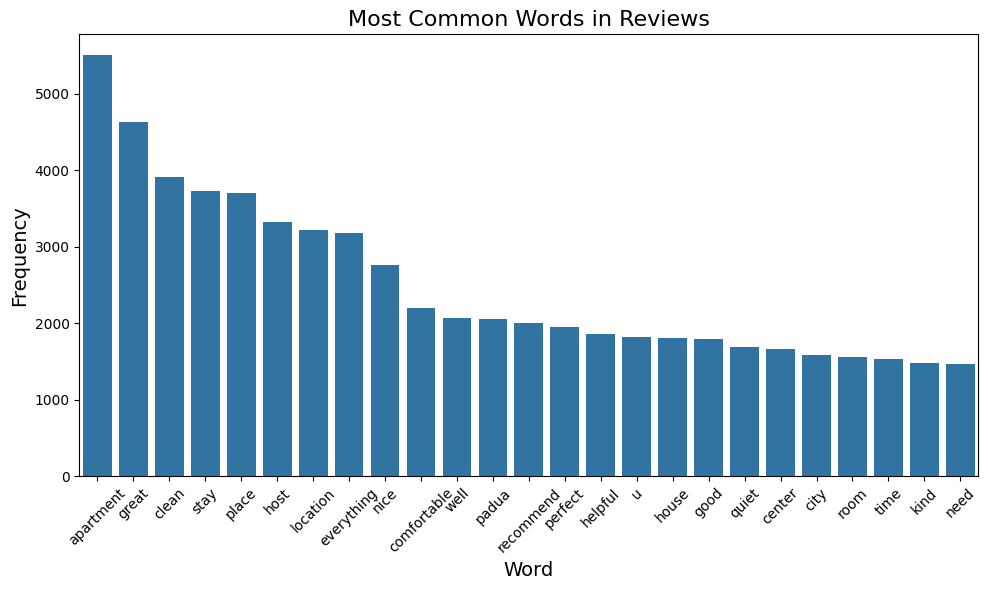

In [ ]:
#Plotting the most common words
processed_reviews = pd.DataFrame({'review_tokens': final_data['Documents'].apply(preprocess_text)})
all_tokens = [token for review in processed_reviews['review_tokens'] for token in review]
word_freq = Counter(all_tokens)
common_words = word_freq.most_common(25)

word_freq_df = pd.DataFrame(common_words, columns=['word', 'frequency'])

# Plot customization
plt.figure(figsize=(10, 6))
sns.barplot(
    x='word',          # Words on the x-axis
    y='frequency',     # Frequency on the y-axis
    data=word_freq_df
)

# Adding labels and title
plt.title('Most Common Words in Reviews', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

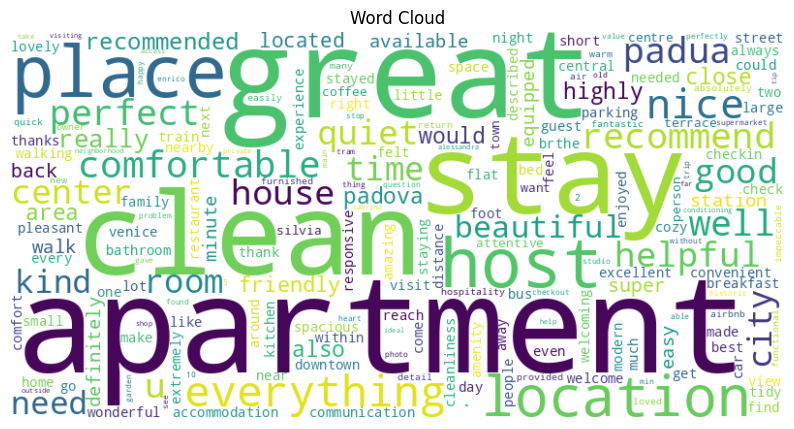

In [ ]:
# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

### How many words per review

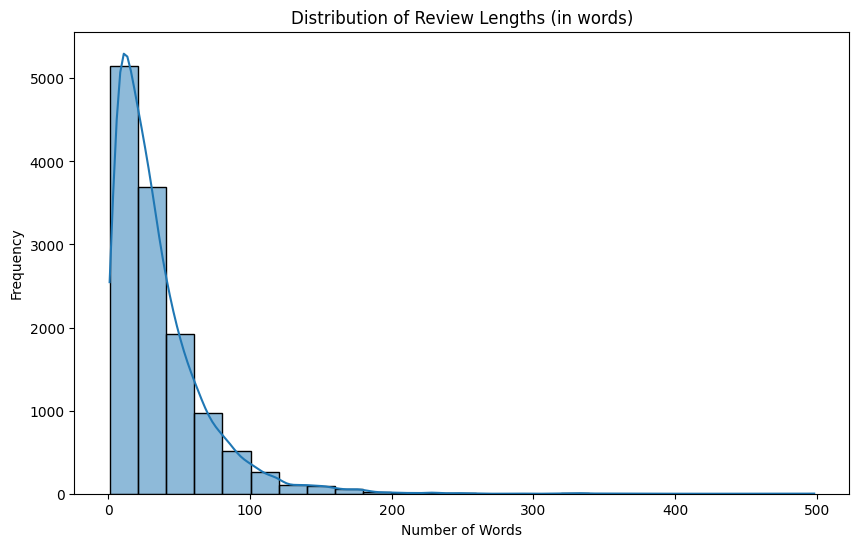

In [ ]:
processed_reviews = pd.DataFrame()

# Count words in each document without preprocessing
processed_reviews['words_count'] = final_data['Documents'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(processed_reviews['words_count'], binwidth=20, kde=True)
plt.title('Distribution of Review Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### How many reviews for accomodation

In [ ]:
grouped = data.groupby('url').size()

# Calculate statistics
average_reviews = grouped.mean()
min_reviews = grouped.min()
max_reviews = grouped.max()

# Display the results
print(f"Average number of reviews per accommodation: {average_reviews}")
print(f"Minimum number of reviews: {min_reviews}")
print(f"Maximum number of reviews: {max_reviews}")

Average number of reviews per accommodation: 110.65178571428571
Minimum number of reviews: 1
Maximum number of reviews: 384


## RAG system

### Loading data

In [ ]:
#Dataframe loader
loader = DataFrameLoader(final_data, page_content_column = 'Documents')  #Documents is used as content, while all other columns are added as metadata
documents = loader.load()

### Text Splitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100,
    length_function = len
)

splitted_documents = text_splitter.transform_documents(documents)
print("The number of final documents is: ", len(splitted_documents))

The number of final documents is:  12896


In [ ]:
token = "insert_here_your_private_token"

notebook_login()

## Embedding model

In [ ]:
import warnings

warnings.filterwarnings("ignore")

#Checking if the length of our documents match the maximum sequence length the embedding model (sentence-transformers/all-mpnet-base-v2) can process

# Load the tokenizer for all-mpnet-base-v2
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Set the maximum token limit
max_token_limit = 384

# Count documents exceeding the token limit
exceeding_documents = [
    doc for doc in splitted_documents
    if len(tokenizer.encode(doc.page_content, truncation=False)) > max_token_limit
]

# Number of documents exceeding the limit
num_exceeding_documents = len(exceeding_documents)

# Print the result
print(f"Number of documents exceeding {max_token_limit} tokens:", num_exceeding_documents)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


Number of documents exceeding 384 tokens: 1


In [ ]:
# Define cache path for storing previously computed embeddings
cache_path = LocalFileStore('./cache/')

# HuggingFace model name for embedding
model_id = 'sentence-transformers/all-MiniLM-L6-v2'

# Initialize the HuggingFace embedding model
embedding_model = HuggingFaceEmbeddings(model_name=model_id)

# Wrap the embedding model with caching
cached_embedder = CacheBackedEmbeddings.from_bytes_store(embedding_model, cache_path, namespace=model_id)

# Initialize Chroma with the cached embedder
vector_store = Chroma(collection_name="apartments", embedding_function=cached_embedder)

# Add texts and metadata to the Chroma vector store
_ = vector_store.add_texts(
   [doc.page_content for doc in splitted_documents],  # Access page_content attribute
   metadatas=[doc.metadata for doc in splitted_documents]  # Access metadata attribute
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Retrieval without metadata filtering

In [ ]:
# Query embedding
query = "We are a couple with a dog and with would like to stay in a room with shared spaces but private bathroom. We would like to stay close to the university area in Portello. Which apartments do you recommend?"
embedding_vector = embedding_model.embed_query(query)


# Perform a similarity search with metadata filtering
docs = vector_store.similarity_search_by_vector(
    embedding_vector,
    k=10
)

# Display results
for idx, doc in enumerate(docs):
    print(f"Document {idx + 1}")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")

Document 1
Content: Beautiful apartment a few minutes from downtown and the university area. Equipped with all the comforts. Highly recommended
Metadata: {'allowChildren': False, 'allowsEvents': False, 'allowsInfant': False, 'allowsPets': False, 'allowsSmoking': False, 'bathroomLabel': '2 bathrooms', 'bedroomLabel': '2 bedrooms', 'city': 'Padua, Veneto, Italy', 'isHostedBySuperhost': False, 'name': 'John&Jack - [Padova FIERA] - Parcheggio Interno', 'personCapacity': 4, 'roomType': 'Entire accommodation: apartment', 'url': 'https://www.airbnb.com/rooms/1146361445697711719'}
Document 2
Content: Really nice and well-maintained room! Private bathroom with bath and kitchen available.  Location not too far from downtown, convenient for all activities
Metadata: {'allowChildren': True, 'allowsEvents': False, 'allowsInfant': True, 'allowsPets': True, 'allowsSmoking': False, 'bathroomLabel': '1 private bathroom', 'bedroomLabel': '1 bedroom', 'city': 'Padua, Veneto, Italy', 'isHostedBySuperhost':

## Retrieval with metadata filtering

### Automatic metadata extraction

In [ ]:
#Prompt to extract metadata from a query: few-shot learning
metadata_extraction_prompt = PromptTemplate(
    input_variables=["query"],
    template="""
You are part of an information system that processes user queries about accommodations in Padua.
Your job is to analyze the user’s query and extract the relevant metadata fields.
Do not output or add any extraneous field which is not part of the list below.

Here is the complete list of possible fields:
- roomType
- bathroomLabel
- bedroomLabel
- allowsChildren
- allowsInfant
- allowsEvent
- allowsPets
- allowsSmoking
- personCapacity
- isHostedBySuperhost

Answer only to the example 5.

###
Example 1:
Query: "I would like to stay in a room in a shared apartment with private bathroom in Padua. I also have a dog, so pets should be allowed.
What is the best accomodation for me?"
Extracted metadata fields: "roomType": "Private room", "bathroomLabel": "1 private bathroom", "allowsPets": True

###
Example 2:
Query: "I am planning a trip near Padua. We're in 4 and we would like to have 2 bedrooms, since there are two children. Some of us also smoke,
so it would be better to have a place where is it possible to do so. What is the best apartment suggested?"
Extracted metadata fields: "personCapacity": 4,"bedroomLabel": "2 bedrooms", "allowsChildren" : True, "allowsSmoking": True

###
Example 3:
Query: "We are a family with a toddler. We would like to stay in an entire apartment with 2 bathrooms in the centre of Padua.
I prefer apartments hosted by a superhost since I think they are more reliable. We would like to invite some friends for Christmas
and do a small party in the house. Which is the best solution to our needs?"
Extracted metadata fields: "roomType": "Entire accommodation", "bathroomLabel": "2 bathrooms", "isHostedBySuperhost": True,
"allowsInfant":True, "allowsEvent":True

###
Example 4:
Query: "I need to do a medical visit. Which apartment is closer to the hospital? I also need 2 rooms since I have children"
Extracted metadata fields: "bedroomLabel": "2 bedrooms", "allowsChildren": True

###
Example 5:
Query: {query}
Extracted metadata fields:
"""
)

#Llama 2 13B with 4-bit config
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "meta-llama/Llama-2-13b-chat-hf"  # or "meta-llama/Llama-2-7b-chat-hf"

model_config = transformers.AutoConfig.from_pretrained(model_id)
model1 = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    config=model_config,
    device_map="auto"
)

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

#Setting evaluation mode
model1.eval()

#Create a text-generation pipeline
generate_text = transformers.pipeline(
    "text-generation",
    model=model1,
    tokenizer=tokenizer,
    max_new_tokens=128,
    do_sample=True,
    temperature =0.1
)

#Wrap in a LangChain LLM
llm = HuggingFacePipeline(pipeline=generate_text)

#Create the LLMChain for metadata extraction
metadata_extraction_chain = LLMChain(
    llm=llm,
    prompt=metadata_extraction_prompt
)


#Extract the metadata as dictionary from the LLM response:
#1) Isolate the text after "Example 5" in the LLM response
#2) Extract everything after that line
#3) Since in addition to the metadata the LLM can continue to generate other words, it's necessary to remove everything
#   after some words that are generated in general (tested multiple times) like "Example", "Extracted metadata" and "Please"
#4) Convert to a valid Python dictionary

def extract_dict(llm_response: str) -> dict:

    #Locate text after "Example 5:"
    parts_5 = llm_response.split("Example 5:")
    if len(parts_5) < 2:
        return {}

    example_5_text = parts_5[1]

    #Split on "Extracted metadata fields:"
    split_extracted = example_5_text.split("Extracted metadata fields:")
    if len(split_extracted) < 2:
        return {}

    extracted_part = split_extracted[1]

    #Remove everything after "Example", "Extracted metadata:", or "Please"
    extracted_part = extracted_part.split("Example")[0]
    extracted_part = extracted_part.split("Please")[0]

    #Clean up whitespaces
    extracted_part = extracted_part.strip()
    if not extracted_part:
        return {}

    #Wrap in curly braces if missing
    if not extracted_part.startswith("{"):
        extracted_part = "{" + extracted_part
    if not extracted_part.endswith("}"):
        extracted_part += "}"

    try:
        metadata_dict = extracted_part
        return metadata_dict
    except Exception:
        print("Warning: Could not parse extracted metadata.\n", extracted_part)
        return {}


#Function to extract the relevant metadata as a dictionary, given a user query
def get_metadata_from_query(query: str) -> dict:

    # Call the LLMChain to get the raw response
    raw_response = metadata_extraction_chain.run(query=query)
    metadata_dict = extract_dict(raw_response)
    return ast.literal_eval(metadata_dict)


#Example user query
user_query = ("We are a couple with a dog and with would like to stay in a room with shared spaces but private bathroom."
    "We would like to stay close to the university area in Portello. Which apartments do you recommend?")
metadata_dict = get_metadata_from_query(user_query)

print("Extracted metadata:", metadata_dict)

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0


Extracted metadata: {'roomType': 'Private room', 'bathroomLabel': '1 private bathroom', 'allowsPets': True, 'location': 'University area in Portello'}


In [ ]:
#Removing extracted metadata which are not the our predefined set
def dict_to_vectorstore_filter(metadata_dict):

    # List of allowed keys
    allowed_keys = [
        "roomType", "bathroomLabel", "bedroomLabel", "allowsChildren",
        "allowsInfant", "allowsEvent", "allowsPets", "allowsSmoking",
        "personCapacity", "isHostedBySuperhost"
    ]

    # Manually filter out keys not in the allowed list
    filtered_data = {key: value for key, value in metadata_dict.items() if key in allowed_keys}

    # Manually construct the metadata_filter with `$and`
    metadata_filter = {"$and": [{key: value} for key, value in filtered_data.items()]}

    return metadata_filter

metadata_filter = dict_to_vectorstore_filter(metadata_dict)

### Retrieval with extracted metadata

In [ ]:
query = "We are a couple with a dog and with would like to stay in a room with shared spaces but private bathroom. We would like to stay close to the university area in Portello. Which apartments do you recommend?"

# Create the retriever with MMR
retriever = vector_store.as_retriever(
    search_type="mmr",  #Maximum Marginal Relevance
    search_kwargs={
        "k": 10,         #Number of results to retrieve
        "lambda": 0.8,   #Balance between relevance (1) and diversity (0)
        "filter": metadata_filter  #Metadata filtering
    }
)

# Perform the MMR-based retrieval
docs = retriever.get_relevant_documents(query)

# Display results
for idx, doc in enumerate(docs):
    print(f"Document {idx + 1}")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")

Document 1
Content: Really nice and well-maintained room! Private bathroom with bath and kitchen available.  Location not too far from downtown, convenient for all activities
Metadata: {'allowsChildren': True, 'allowsEvents': False, 'allowsInfant': True, 'allowsPets': True, 'allowsSmoking': False, 'bathroomLabel': '1 private bathroom', 'bedroomLabel': '1 bedroom', 'city': 'Padua, Veneto, Italy', 'isHostedBySuperhost': False, 'name': 'Camera romantica con vasca idromassaggio!', 'personCapacity': 2, 'roomType': 'Private room', 'url': 'https://www.airbnb.com/rooms/30724154'}
Document 2
Content: Functional room with private bathroom not far from the center of Padua.
Metadata: {'allowsChildren': False, 'allowsEvents': False, 'allowsInfant': False, 'allowsPets': True, 'allowsSmoking': False, 'bathroomLabel': '1 private bathroom', 'bedroomLabel': '1 bedroom', 'city': 'Padua, Veneto, Italy', 'isHostedBySuperhost': True, 'name': 'Camera Tua® J4 •Camera con bagno •Centro/Ospedali', 'personCapaci

## Context-aware response generation

In [ ]:
#Text generation pipeline
generate_text = transformers.pipeline(
    model=model1,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    do_sample=True,
    temperature=0.1,
    max_new_tokens=512
)
llm = HuggingFacePipeline(pipeline=generate_text)

Device set to use cuda:0


In [ ]:
#Designed prompt for question-answering
template = (
    """
    <s>[INST]
    You are an assistant for question-answering tasks.
    The theme of the questions is: AirBnB reviews and house rules in Padua and province.
    Use the following pieces of retrieved context to answer the question.
    Feel free to ignore some context if it is not useful for the answer.
    If you don't know the answer or the retrieved context does not contain
    any information about the question, clearly apologize and state that you don’t know.
    Please ensure your responses are supported by the information from the retrieved documents.

    </s>
    [INST]
    Context: {context}
    [/INST]
    Question: {question}
    Helpful Answer:
    """
)


# this document template allows us to pass metadata to the model
# otherwise only page_content is used
document_prompt = PromptTemplate(
    input_variables = ['page_content', 'name', 'bathroomLabel', 'bedroomLabel', 'allowsChildren', 'allowEvents', 'allowsInfant',
                       'allowsSmoking','personCapacity','isHostedBySuperhost','roomType'],
    template = """
        name: {name};
        number of bathrooms: {bathroomLabel}
        number of bedrooms: {bedroomLabel};
        allows children: {allowsChildren};
        allows events: {allowsEvents};
        allows infant: {allowsInfant};
        allows pets: {allowsPets};
        allows smoking: {allowsSmoking};
        person capacity: {personCapacity};
        is hosted by a superhost: {isHostedBySuperhost};
        room type: {roomType};
        review or house rule: {page_content}"""
)


### Question-answering with NAIVE retrieval

In [ ]:
#Retriever based on the vector store to perform sentence similarity searches
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 10})

#Callback for std out
stdout_handler = StdOutCallbackHandler()

#QA chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type = "stuff",
    retriever = retriever,
    callbacks=[stdout_handler],
    chain_type_kwargs = {
        "prompt": PromptTemplate(template=template, input_variables=[]),
        "document_prompt": document_prompt
    },
    return_source_documents=True
)

In [ ]:
#Helper function to get a cleaner output
def display_response(answer):
    print(f'QUESTION: {answer["query"]}\n')
    print(f'MODEL ANSWER:\n{answer["result"].split("Helpful Answer:")[-1].strip()}\n')
    print('RETRIEVED DOCUMENTS:')
    for idx, doc in enumerate(answer['source_documents']):
        print(f'Document n. {idx+1}:\nContent: {doc.page_content}\nMetadata: {doc.metadata}\n')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from transformers import logging

logging.set_verbosity_error()

def evaluate_answer(answer, query):
    # Extract the "Helpful Answer" part
    text = answer['result']
    if "Helpful Answer:" in text:
        generated_text = text.split("Helpful Answer:")[1].strip()

    # Compute BERTScore
    P, R, F1 = score([generated_text], [query], lang="en")
    bert_score_f1 = F1.mean().item()

    # Load GPT-2 tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model = GPT2LMHeadModel.from_pretrained("gpt2")

    # Calculate perplexity
    inputs = tokenizer(generated_text, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"])
    perplexity = torch.exp(outputs.loss).item()


    # Return results
    return {
        "BERTScore_F1": bert_score_f1,
        "Perplexity": perplexity
    }

In [ ]:
query = "We are a couple with a dog and with would like to stay in a room with shared spaces but private bathroom. We would like to stay close to the university area in Portello. Which apartments do you recommend?"
answer = qa({'query' : query})
display_response(answer)



> Entering new RetrievalQA chain...

> Finished chain.
QUESTION: We are a couple with a dog and with would like to stay in a room with shared spaces but private bathroom. We would like to stay close to the university area in Portello. Which apartments do you recommend?

MODEL ANSWER:
Based on your preferences, I would recommend the following apartments:
    
    * C-Apartment Zabarella Luxury Terrace Apt.: It has a private bathroom, a comfortable living room, and a beautiful terrace. It is located in a central area, just a stone's throw from the University of Padua.
    
    * Stanza vicino Università/Centro - Padova City Stop: The room is spacious and bright, with a spacious desk, and has a private bathroom. The house is located near the university and Porta Portello, and the area is very peaceful. The hosts are friendly and helpful!
    
    Both of these apartments are hosted by a superhost, and they allow pets, so you can bring your dog with you. Additionally, they have a high ra

In [ ]:
print(evaluate_answer(answer, query))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

{'BERTScore_F1': 0.821987509727478, 'Perplexity': 22.817699432373047}


### Question-answering with self-query retrieval

In [ ]:
#Retriever based on the vector store to perform MMR search

retriever = vector_store.as_retriever(
    search_type="mmr",  #Maximum Marginal Relevance
    search_kwargs={
        "k": 10,         #Number of results to retrieve
        "lambda": 0.8,   #Balance between relevance (1) and diversity (0)
        "filter": metadata_filter  #Metadata filtering
    }
)

#Callback for std out
stdout_handler = StdOutCallbackHandler()

# QA chain
qa_selfquery = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type = "stuff",
    retriever = retriever,
    callbacks=[stdout_handler],
    chain_type_kwargs = {
        "prompt": PromptTemplate(template=template, input_variables=[]),
        "document_prompt": document_prompt
    },
    return_source_documents=True
)

In [ ]:
query = "We are a couple with a dog and with would like to stay in a room with shared spaces but private bathroom. We would like to stay close to the university area in Portello. Which apartments do you recommend?"

In [ ]:
answer = qa_selfquery({'query' : query})
display_response(answer)



> Entering new RetrievalQA chain...

> Finished chain.
QUESTION: We are a couple with a dog and with would like to stay in a room with shared spaces but private bathroom. We would like to stay close to the university area in Portello. Which apartments do you recommend?

MODEL ANSWER:
Based on the provided context, I would recommend the following apartments that meet your requirements:
    
    * Camera Tua® C1 • Suite con cucina •Centro/Ospedali: This apartment is located in the university area, has a private bathroom, and allows pets. It is a stylish mini-apartment that can accommodate up to 4 people, including children and infants.
    
    * Camera Tua® C5•Camera con bagno • Centro/Ospedali: This apartment is also located in the university area, has a private bathroom, and allows pets. It is a small but functional apartment with air conditioning, and the manager is friendly and helpful.
    
    Both of these apartments are hosted by a superhost, which means they have a high ratin

In [ ]:
from transformers import logging

logging.set_verbosity_error()

print(evaluate_answer(answer, query))

{'BERTScore_F1': 0.8251139521598816, 'Perplexity': 12.375901222229004}


## Summing everything up

In [ ]:
def qa_system(query):
    start_time = time.time()
    answer = qa({'query' : query})
    end_time = time.time()
    naive_time = end_time - start_time
    print("NAIVE approach")
    print(f"The time needed to respond to the user query is: {naive_time:.2f}")
    display_response(answer)
    print(evaluate_answer(answer, query))

    start_time_sf = time.time()
    metadata_dict = get_metadata_from_query(query)
    metadata_filter = dict_to_vectorstore_filter(metadata_dict)
    qa_selfquery.retriever.search_kwargs['filter'] = metadata_filter

    answer_sf = qa_selfquery({'query' : query})
    end_time_sf = time.time()
    sf_time = end_time_sf - start_time_sf
    print("Self-query approach")
    print("Extracted metadata:", metadata_filter)
    print(f"The time needed to respond to the user query is: {sf_time:.2f}")
    display_response(answer_sf)
    print()
    print(evaluate_answer(answer_sf, query))
    return

In [ ]:
qa_system("We are a family with a child of 5 years old. We would like to stay in an apartment with 2 bedrooms and I need to work, so"
         "ultra-fast Wi-Fi is required.Which is the best accomodation for us which is also safe for my baby?")



> Entering new RetrievalQA chain...

> Finished chain.
NAIVE approach
The time needed to respond to the user query is: 59.82
QUESTION: We are a family with a child of 5 years old. We would like to stay in an apartment with 2 bedrooms and I need to work, soultra-fast Wi-Fi is required.Which is the best accomodation for us which is also safe for my baby?

MODEL ANSWER:
Based on the provided context, I would recommend "Camera Tua® C5•Camera con bagno • Centro/Ospedali" for your stay. It is a private room with a shared bathroom, located in the city center, and has a child-friendly environment. The host allows children and provides a high-speed Wi-Fi connection, which is essential for your work needs. Additionally, the apartment is well-equipped and has a patio, which can be a safe and enjoyable space for your child to play.

    Another option to consider is "Oasi centrale con patio privato", which is also located in the city center and has a private patio. The host allows children and p

In [ ]:
qa_system("We are a group of 6 people that are going to stay in Padua for a weekend. We would like to stay in an entire apartment, with two rooms and "
          "two bathrooms. We trust only superhosts because they are more relialable. What accommodation would you recommend?")



> Entering new RetrievalQA chain...

> Finished chain.
NAIVE approach
The time needed to respond to the user query is: 40.56
QUESTION: We are a group of 6 people that are going to stay in Padua for a weekend. We would like to stay in an entire apartment, with two rooms and two bathrooms. We trust only superhosts because they are more relialable. What accommodation would you recommend?

MODEL ANSWER:
Based on the provided context, I would recommend "Elegant design apartment in Padua" or "Patavium Apartment". Both of these accommodations meet your requirements of an entire apartment with two rooms and two bathrooms, and they are hosted by superhosts.
    
    "Elegant design apartment in Padua" is a modern and spacious apartment located in the city center, within walking distance to all major attractions. It has two bedrooms, two bathrooms, and a fully equipped kitchen. The host is very responsive and helpful.
    
    "Patavium Apartment" is a cozy and well-equipped apartment located 

In [ ]:
qa_system("We are a family of 4 people and we are going to spend a week in Veneto. We would like to stay in the countryside of Padua and since me and my"
          "son smoke, it would be better if it's allowed in the apartment. Which solution do you suggest?")



> Entering new RetrievalQA chain...

> Finished chain.
NAIVE approach
The time needed to respond to the user query is: 66.48
QUESTION: We are a family of 4 people and we are going to spend a week in Veneto. We would like to stay in the countryside of Padua and since me and myson smoke, it would be better if it's allowed in the apartment. Which solution do you suggest?

MODEL ANSWER:
Based on your requirements, I suggest you consider the following options:
    
    - "Come a casa mia - Centro città": it's a cozy apartment located in the city center of Padua, with a maximum capacity of 3 people. Smoking is not allowed inside the apartment, but you can smoke on the terrace.
    
    - "Il piccolo giardino del Ginko": it's a charming apartment located in a quiet area of Padua, with a maximum capacity of 5 people. Smoking is not allowed inside the apartment, but you can smoke in the garden.
    
    - "Il cottage di Petali e Seta. Comodo alla città": it's a comfortable apartment located i

## General questions

In [ ]:
start_time = time.time()
answer = qa({'query' : "What are the recurring complaints in Airbnb reviews of properties in Padua?"})
end_time = time.time()
naive_time = end_time - start_time
print("NAIVE approach")
print(f"The time needed to respond to the user query is: {naive_time:.2f}")
display_response(answer)
print(evaluate_answer(answer, query))




> Entering new RetrievalQA chain...

> Finished chain.
NAIVE approach
The time needed to respond to the user query is: 56.80
QUESTION: What are the recurring complaints in Airbnb reviews of properties in Padua?

MODEL ANSWER:
Based on the reviews provided, the following are recurring complaints in Airbnb reviews of properties in Padua:

1. Lack of smoking: Many reviews mention that the property does not allow smoking, which may be a concern for smokers.
2. Limited parking: Some reviews mention limited parking options, which may be a challenge for guests with cars.
3. Noise: A few reviews mention noise from the street or other guests, which may be a concern for those who prefer a quieter environment.
4. Cleanliness: One review mentions that the property was not as clean as expected, which may be a concern for guests who prioritize cleanliness.
5. Infant policy: Some reviews mention that the property has a no-infant policy, which may be a challenge for families with infants.
6. Limited

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'BERTScore_F1': 0.822812557220459, 'Perplexity': 10.170909881591797}


In [ ]:
start_time = time.time()
answer = qa({'query' : "Which Airbnb properties in Padua offer the best value for money, according to guest reviews?"})
end_time = time.time()
naive_time = end_time - start_time
print("NAIVE approach")
print(f"The time needed to respond to the user query is: {naive_time:.2f}")
display_response(answer)
print(evaluate_answer(answer, query))



> Entering new RetrievalQA chain...

> Finished chain.
NAIVE approach
The time needed to respond to the user query is: 61.90
QUESTION: Which Airbnb properties in Padua offer the best value for money, according to guest reviews?

MODEL ANSWER:
Based on the provided context, the following Airbnb properties in Padua offer the best value for money, according to guest reviews:

1. Dolce vita Padova centro - This property has a perfect rating of 5 stars and is described as "excellent" by guests. It offers great value for money, with a spacious and clean apartment in a central location.

2. C-Apartment Zabarella Luxury Terrace Apt. - This property also has a perfect rating of 5 stars and is described as "over the top" by guests. It offers a luxurious and well-equipped apartment with a great location and excellent host.

3. Elegant design apartment in Padua - This property has a rating of 4.9 stars and is described as "spotlessly clean" and "comfortable" by guests. It offers a well-furnished

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'BERTScore_F1': 0.7996176481246948, 'Perplexity': 10.05956745147705}


In [ ]:
start_time = time.time()
answer = qa({'query' : "How are properties hosted by superhosts compared to other listings in Padua?"})
end_time = time.time()
naive_time = end_time - start_time
print("NAIVE approach")
print(f"The time needed to respond to the user query is: {naive_time:.2f}")
display_response(answer)
print(evaluate_answer(answer, query))



> Entering new RetrievalQA chain...

> Finished chain.
NAIVE approach
The time needed to respond to the user query is: 29.70
QUESTION: How are properties hosted by superhosts compared to other listings in Padua?

MODEL ANSWER:
Based on the provided context, it appears that properties hosted by superhosts in Padua have several advantages. Firstly, they are more likely to have a higher rating and more reviews, indicating a better guest experience. Secondly, they are more likely to have a well-maintained house space, with cleanliness being a top priority. Additionally, superhosts are more likely to provide detailed and timely information about everything guests need, making the check-in process easier and more convenient. Finally, superhosts are more likely to have a more central location, with some listings being within walking distance to downtown Padua. Overall, properties hosted by superhosts in Padua appear to offer a more comfortable, convenient, and high-quality stay compared to 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'BERTScore_F1': 0.8303738832473755, 'Perplexity': 15.863451957702637}


## Unrelated questions test

In [ ]:
start_time = time.time()
answer = qa({'query' : "Can you give me information about Japanese restaurants in Padua?"})
end_time = time.time()
naive_time = end_time - start_time
print("NAIVE approach")
print(f"The time needed to respond to the user query is: {naive_time:.2f}")
display_response(answer)
print(evaluate_answer(answer, query))



> Entering new RetrievalQA chain...

> Finished chain.
NAIVE approach
The time needed to respond to the user query is: 37.16
QUESTION: Can you give me information about Japanese restaurants in Padua?

MODEL ANSWER:
Based on the retrieved context, there is no direct mention of Japanese restaurants in Padua. However, some of the accommodations provide recommendations for local restaurants and bars. For example, the review for "DELIZIOSO MINI IN CENTRO STORICO" mentions trying Italian food and getting great suggestions from the hosts. Additionally, "Bilocale Albertinus, alle riviere" provides personal welcome and good restaurant recommendations for the evening.

    If you're looking for Japanese restaurants specifically, you may want to try searching online or checking with local tourism boards for recommendations. Alternatively, you could also ask your accommodation host for any recommendations they may have.

    Please note that while some accommodations allow children, events, and 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'BERTScore_F1': 0.8069566488265991, 'Perplexity': 46.32976531982422}
